## Load packages

In [1]:
library(pROC)

Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var



## Import donors data
The goal is to predict whether person will donate using logistic regression (binary classification)

In [2]:
donors = read.csv("data/donors.csv")
head(donors)
str(donors)

donated,veteran,bad_address,age,has_children,wealth_rating,interest_veterans,interest_religion,pet_owner,catalog_shopper,recency,frequency,money
0,0,0,60,0,0,0,0,0,0,CURRENT,FREQUENT,MEDIUM
0,0,0,46,1,3,0,0,0,0,CURRENT,FREQUENT,HIGH
0,0,0,NA,0,1,0,0,0,0,CURRENT,FREQUENT,MEDIUM
0,0,0,70,0,2,0,0,0,0,CURRENT,FREQUENT,MEDIUM
0,0,0,78,1,1,0,1,0,1,CURRENT,FREQUENT,MEDIUM
0,0,0,NA,0,0,0,0,0,0,CURRENT,INFREQUENT,MEDIUM


'data.frame':	93462 obs. of  13 variables:
 $ donated          : int  0 0 0 0 0 0 0 0 0 0 ...
 $ veteran          : int  0 0 0 0 0 0 0 0 0 0 ...
 $ bad_address      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ age              : int  60 46 NA 70 78 NA 38 NA NA 65 ...
 $ has_children     : int  0 1 0 0 1 0 1 0 0 0 ...
 $ wealth_rating    : int  0 3 1 2 1 0 2 3 1 0 ...
 $ interest_veterans: int  0 0 0 0 0 0 0 0 0 0 ...
 $ interest_religion: int  0 0 0 0 1 0 0 0 0 0 ...
 $ pet_owner        : int  0 0 0 0 0 0 1 0 0 0 ...
 $ catalog_shopper  : int  0 0 0 0 1 0 0 0 0 0 ...
 $ recency          : Factor w/ 2 levels "CURRENT","LAPSED": 1 1 1 1 1 1 1 1 1 1 ...
 $ frequency        : Factor w/ 2 levels "FREQUENT","INFREQUENT": 1 1 1 1 1 2 2 1 2 2 ...
 $ money            : Factor w/ 2 levels "HIGH","MEDIUM": 2 1 2 2 2 2 2 2 2 2 ...


## Create Logistic Regression Model
Use RFM (recency, frequency, monetary) analysis which is a marketing technique for the prediction.

In [3]:
rfm_model <- glm(donated ~ recency * frequency + money, data = donors, family = "binomial")
summary(rfm_model)


Call:
glm(formula = donated ~ recency * frequency + money, family = "binomial", 
    data = donors)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.3696  -0.3696  -0.2895  -0.2895   2.7924  

Coefficients:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                       -3.01142    0.04279 -70.375   <2e-16 ***
recencyLAPSED                     -0.86677    0.41434  -2.092   0.0364 *  
frequencyINFREQUENT               -0.50148    0.03107 -16.143   <2e-16 ***
moneyMEDIUM                        0.36186    0.04300   8.415   <2e-16 ***
recencyLAPSED:frequencyINFREQUENT  1.01787    0.51713   1.968   0.0490 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 37330  on 93461  degrees of freedom
Residual deviance: 36938  on 93457  degrees of freedom
AIC: 36948

Number of Fisher Scoring iterations: 6


## Use ROC curve to evaluate the model
The idea is to plot TPR (True positive rate) vs FPR (False positive rate) over different cutoffpoints

[1] "Area under curve is 0.578489371262516"


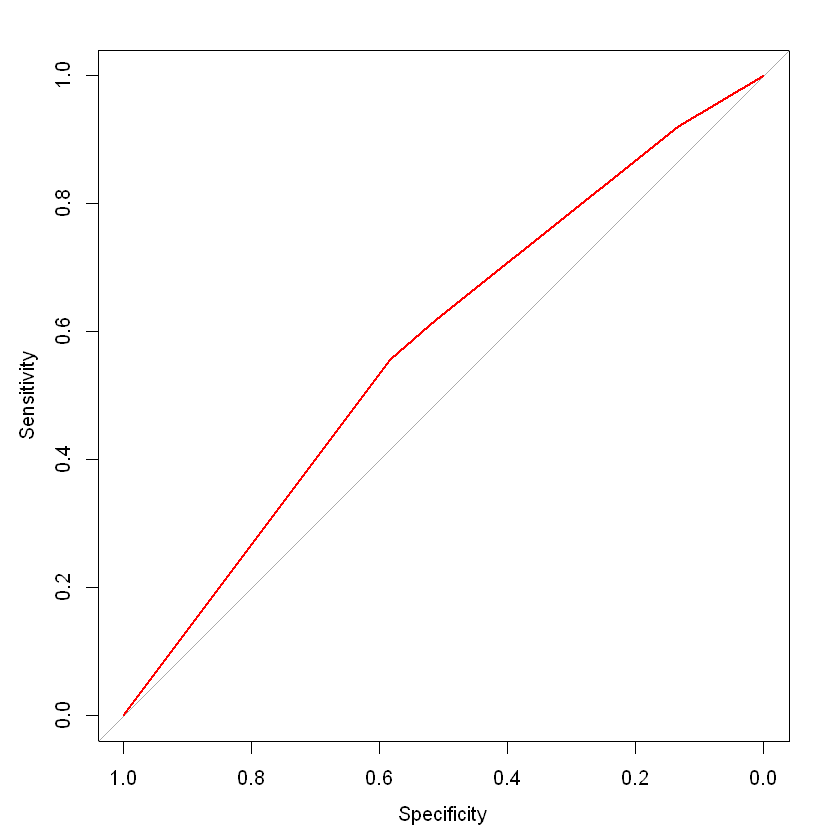

In [4]:
rfm_prob = predict(rfm_model, data = donors, type = "response")
ROC = roc(donors$donated, rfm_prob)
plot(ROC, col = "red")
print(paste("Area under curve is", auc(ROC)))

## Simple prediction by setting cutoff = mean

In [5]:
donation_pred = predict(rfm_model, type = "response")
donation_rate = mean(donors$donated)
donation_pred = ifelse(donation_pred > donation_rate, 1, 0)

print("Confusion matrix:")
table(donors$donated, donation_pred)
print(paste("Accuracy:", mean(donors$donated == donation_pred)))

[1] "Confusion matrix:"


   donation_pred
        0     1
  0 52002 36749
  1  2092  2619

[1] "Accuracy: 0.584419336200809"


## Feature selection by using stepwise regression
Features are selected from either
* Empty subset to Full subset (Forward), or 
* Full subset to Empty subset (Backward)      

while for each successful iteration is an improvement of model

In [6]:
# Use forward stepwise algorithm
options(warn=-1)
null_model = glm(donated ~ 1, data = donors, family = "binomial")
full_model = glm(donated ~ ., data = donors, family = "binomial")
step_model = step(null_model, scope = list(lower = null_model, upper = full_model), direction = "forward")
options(warn=0)

Start:  AIC=37332.13
donated ~ 1

                    Df Deviance   AIC
+ frequency          1    28502 37122
+ money              1    28621 37241
+ wealth_rating      1    28705 37326
+ has_children       1    28705 37326
+ age                1    28707 37328
+ interest_veterans  1    28709 37330
+ catalog_shopper    1    28710 37330
+ pet_owner          1    28711 37331
<none>                    28714 37332
+ interest_religion  1    28712 37333
+ recency            1    28713 37333
+ bad_address        1    28714 37334
+ veteran            1    28714 37334

Step:  AIC=37024.77
donated ~ frequency

                    Df Deviance   AIC
+ money              1    28441 36966
+ wealth_rating      1    28493 37018
+ has_children       1    28494 37019
+ interest_veterans  1    28498 37023
+ catalog_shopper    1    28499 37024
+ age                1    28499 37024
+ pet_owner          1    28499 37024
<none>                    28502 37025
+ interest_religion  1    28501 37026
+ recency   

## Use ROC curve to evaluate the model

[1] "Area under curve is 0.585470794088965"


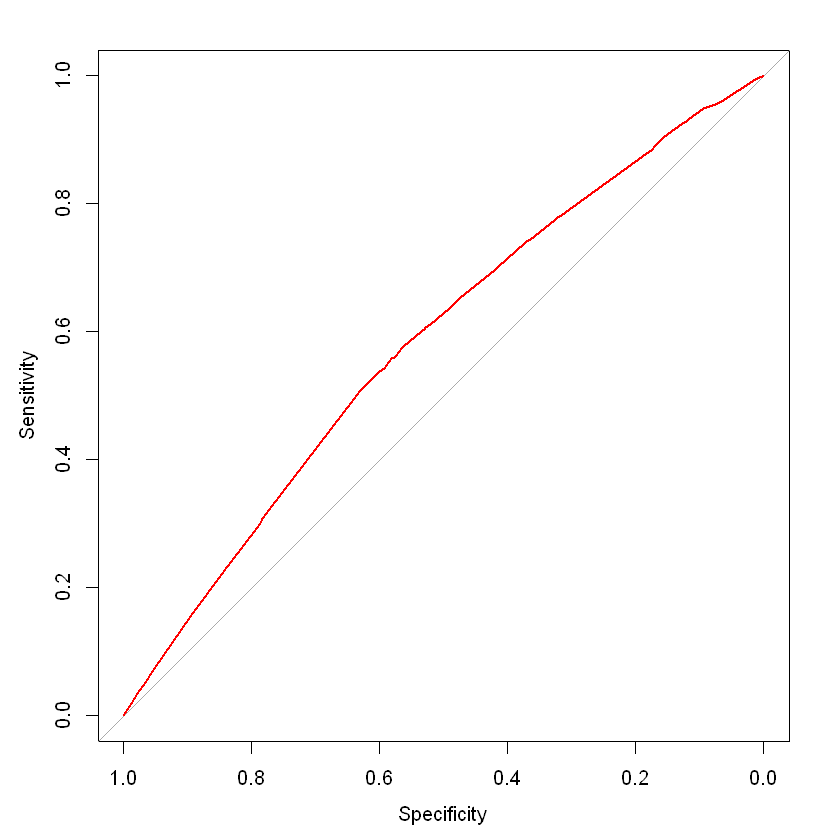

In [7]:
step_prob <- predict(step_model, type = "response")
ROC <- roc(donors$donated, step_prob)
plot(ROC, col = "red")
print(paste("Area under curve is", auc(ROC)))